# Proyecto Final

Integrantes:
- Kroko
- Alan
- Nandy

### Enunciado

En este proyecto tendrá que trabajar con datos reales del departamento de la policía de la ciudad de nueva york y se enmarca en el contexto de seguridad y criminalidad en los barrios de la ciudad. **El objetivo de este proyecto es predecir la cantidad de delitos cada cierto tipo por barrio.**





El conjunto de datos a utilizar proviene de la página de datos abiertos de la ciudad de NY. (https://opendata.cityofnewyork.us) y comprenden datos desde el 2013 hasta el 2020 de arrestos, colisiones vehiculares y denuncias ciudadanas.

El dataset contiene diversos registros de distintos tipos de crimenes, en este estudio debe centrarse en los siguientes:
1. Delitos (Felonies)
2. Faltas (Misdemeanors)
3. Violaciones (Violations)

Esta categorización puede ser encontrada en la variable "LAW_CAT_CD"

Los barrios de estudio son:
- Staten Island
- Brooklyn
- Queens
- Manhattan
- Bronx

### Requerimientos



1. Seleccione al menos dos barrios de la ciudad y obtenga estimaciones de la cantidad de delitos, por tipo, ocurridos en la ciudad de NY semana a semana usando como conjunto de entrenamiento toda la data hasta el 2019 y como conjunto de pruebas el año 2020 completo. Compare distintas aproximaciones de modelamiento utilizando las métricas y modelos vistos en clases aunque se permite tambien usar métricas/modelos no discutidos (siempre y cuando se utilicen de manera correcta).
2. Deberá almacenar la informacion en una base de datos Postgres con el esquema de datos que usted prefiera
3. Utilizando Apache Airflow, cree un DAG que contenga al menos las siguientes tasks:
    - Data Processing: Extraerá la informacion de la based de datos Postgres
    - Data Processing: Procesará la informacióin extraida en la etapa anterior realizando todas las tareas de ingeniería de atributos que usted estime conveniente para sus modelos
    - Model Training: Utilizando la información generada en el punto anterior esta tasa debe ajustar los modelos a la data histórica con los hiperparámetros y configuración que usted haya estimado conveniente de su experimentación previa, una vez finalizado el entrenamiento debe almacenar el modelo donde usted estime conveniente. Este paso se debe realizar solo si no existe un modelo previamente entrenado, en cuyo caso se debe omitir este paso y pasar directamente al siguiente.
    - Model Inference: Utilizando un modelo ya entrenado, realice inferencias sobre el conjunto de pruebas y estas sean guardadas en una tabla de postgres.

4. Genere un informe breve donde se explique la metodología que utilizó para realizar los modelos justificando las decisiones tomadas a partir de lo observado en la experimientación. Explique tambien la infraestructura y el DAG generado.

### Consideraciones:


- Se recomienda realizar la experimentación sobre los datos en Jupyter para determinar la mejor configuración de los modelos de series de tiempo, una vez que haya obtenido un modelo con resultados satisfactorios incluya esta configuración en la tasa de Model Training.
- Sus modelos deben hacer predicciones a nivel semana, es decir, debe ser capaz de entregar para cada semana del 2020 disponible en los datos la cantidad de delitos de cada tipo que ocurrirán por barrio.
- Note que no se especificó la forma en que se debe pasar la informacion de una task a la siguiente, esto queda a criterio del equipo ya que hay muchas formas de hacerlo. Estudie e investigue cual es la que más le conviene para su caso o considear que es correcta. Lo mismo para el modelo en si.
- El entregable subido a aula debe contener al menos el notebook con los experimentos realizados, al menos un archivo .py con la definicion del DAG/tasks, el informe en formato PDF, un dump de la base de datos en formato .sql con las tablas que haya utilizado ya pobladas junto con un archivo en formato .txt o .json con la información necesaria para conectarse a la base de datos, y en caso de ser necesario, el modelo entrenado.
- Puesto que le pide usar una base de datos para almacenar la informacion durante las tasks necesitará hacer una conexión desde Python a Postgres: Queda prohibido incluir información sensible sobre la conexión al motor en los archivos .py, se le sugiere crear un archivo de configuracion en formato .json  (o el que guste) y que este sea leido simplemente desde el codigo, demas esta decir que si usa alguna herramienta de versionamiento de codigo ese archivo no deberia ser subido aunque para los efectos de la tarea subalo junto con el resto de los entregables. 
- Entregar codigo con informacion sensible sobre las conexiones al motor incurrirá en descuentos de puntaje
- Algo que le sera util es usar Docker.
- Este proyecto puede ser realizado en grupos de máximo tres personas.

## Pregunta 1: 

Selección de barrios y exploración de datos

In [4]:
import pandas as pd
import sklearn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

Seleccionamos del dataset aquellos registros de 2019 y 2020 para su posterior uso

In [5]:
# ya que debemos ocupar el 2019 como entrenamiento, y el 2020 como prueba, vamos a sacar slices de la data.

# df = pd.read_csv("./Data/NYPD_Arrests_Data__Historic_.csv")
# df.head()

In [6]:
# df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"])
# df_2019 = df[df["ARREST_DATE"].dt.year == 2019]
# df_2020 = df[df["ARREST_DATE"].dt.year == 2020]
# df_2019.info()

In [7]:
## Lo guardamos en un CSV para su manipulación:

# df_2019.to_csv("./Data/NYPD_ARRESTS_DATA_2019.csv", index=False)
# df_2020.to_csv("./Data/NYPD_ARRESTS_DATA_2020.csv", index=False)

### EDA:

In [8]:
## Revisamos los datasets para Train y Test

df_2019 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2019.csv")
df_2020 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2020.csv")

print("Train data: ", df_2019.shape)
print("Test data: ",df_2020.shape)

Train data:  (213248, 19)
Test data:  (139024, 19)


Data Cleaning:

In [9]:
print("Train missing values:")
print(df_2019.isnull().sum())
print()
print("Test missing values:")
print(df_2020.isnull().sum())
print()
print("Train duplicated: ", df_2019.duplicated().sum())
print("Test duplicated: ", df_2020.duplicated().sum())

Train missing values:
ARREST_KEY             0
ARREST_DATE            0
PD_CD                 41
PD_DESC              159
KY_CD                159
OFNS_DESC            159
LAW_CODE               0
LAW_CAT_CD             0
ARREST_BORO            0
ARREST_PRECINCT        0
JURISDICTION_CODE      0
AGE_GROUP              0
PERP_SEX               0
PERP_RACE              0
X_COORD_CD             0
Y_COORD_CD             0
Latitude               0
Longitude              0
Lon_Lat                0
dtype: int64

Test missing values:
ARREST_KEY            0
ARREST_DATE           0
PD_CD                23
PD_DESC              37
KY_CD                37
OFNS_DESC            37
LAW_CODE              0
LAW_CAT_CD            0
ARREST_BORO           0
ARREST_PRECINCT       0
JURISDICTION_CODE     0
AGE_GROUP             0
PERP_SEX              0
PERP_RACE             0
X_COORD_CD            0
Y_COORD_CD            0
Latitude              0
Longitude             0
Lon_Lat               0
dtype: int64

In [10]:
df_2019.dropna(subset=["LAW_CAT_CD"], inplace=True)
df_2020.dropna(subset=["LAW_CAT_CD"], inplace=True)

In [11]:
df_2019.dtypes

ARREST_KEY             int64
ARREST_DATE           object
PD_CD                float64
PD_DESC               object
KY_CD                float64
OFNS_DESC             object
LAW_CODE              object
LAW_CAT_CD            object
ARREST_BORO           object
ARREST_PRECINCT        int64
JURISDICTION_CODE    float64
AGE_GROUP             object
PERP_SEX              object
PERP_RACE             object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lon_Lat               object
dtype: object

In [12]:
# Convertiremos estos datos en algo legible a continuacion:

df_2019["LAW_CAT_CD"] = df_2019["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2020["LAW_CAT_CD"] = df_2020["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2019["ARREST_BORO"] = df_2019["ARREST_BORO"].replace({"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"})
df_2020["ARREST_BORO"] = df_2020["ARREST_BORO"].replace({"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"})

df_2019.head()


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,Felony,Manhattan,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)
1,193260691,2019-02-06,NaN,NaN,NaN,NaN,PL 2203400,Felony,Manhattan,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007)
2,196324211,2019-04-23,157.0,RAPE 1,104.0,RAPE,PL 1303501,Felony,Brooklyn,77,0.0,45-64,M,BLACK HISPANIC,1003606.0,185050.0,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)
3,196785901,2019-05-04,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,Misdemeanor,Bronx,50,0.0,25-44,M,BLACK,1011257.0,261130.0,40.883383,-73.902333,POINT (-73.90233330899997 40.88338257900006)
4,197554056,2019-05-23,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,Misdemeanor,Manhattan,26,0.0,45-64,F,BLACK,996241.0,236149.0,40.814850,-73.956682,POINT (-73.95668184799996 40.81485028900005)


Ahora si, la 1


In [13]:
train_data = df_2019.copy()
test_data = df_2020.copy()

# Convertimos la fecha en un formato legible para el modelo:
train_data['ARREST_DATE'] = pd.to_datetime(train_data['ARREST_DATE'])
test_data['ARREST_DATE'] = pd.to_datetime(test_data['ARREST_DATE'])

In [14]:


# Count arrests per week for train_data
train_arrest_count = train_data.groupby([pd.Grouper(key='ARREST_DATE', freq='W'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')

# Count arrests per week for test_data
test_arrest_count = test_data.groupby([pd.Grouper(key='ARREST_DATE', freq='W'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')


train_arrest_count.head()

,ARREST_DATE,LAW_CAT_CD,ARREST_BORO,ARREST_COUNT
0,2019-01-06,Felony,Bronx,275
1,2019-01-06,Felony,Brooklyn,473
2,2019-01-06,Felony,Manhattan,310
3,2019-01-06,Felony,Queens,282
4,2019-01-06,Felony,Staten Island,59


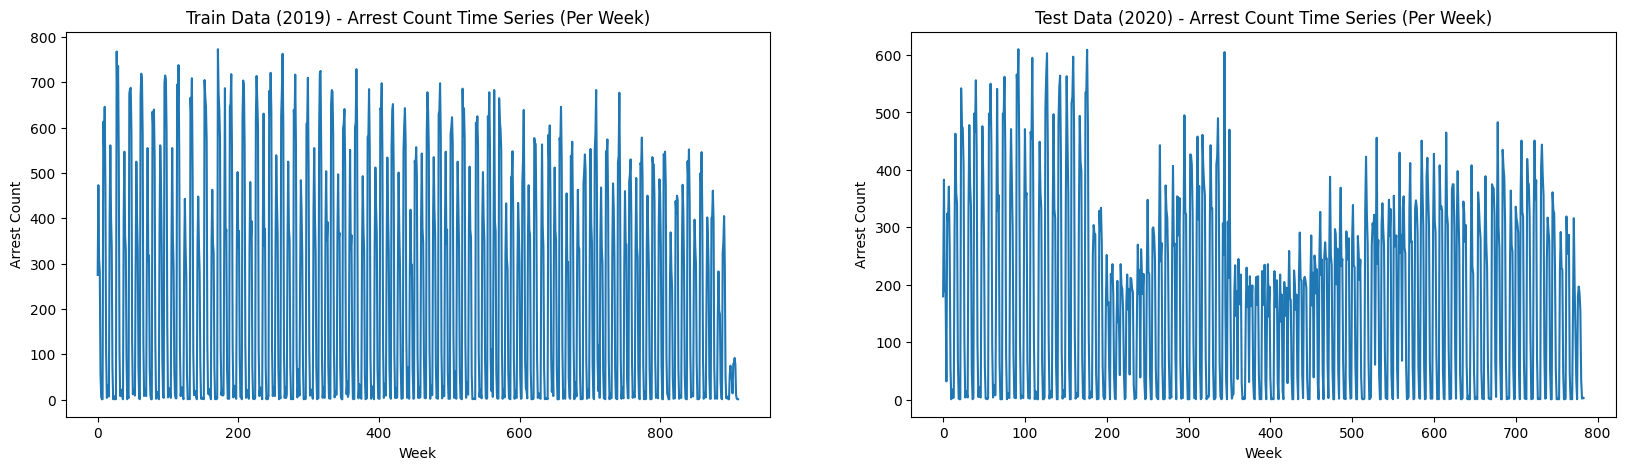

In [15]:
# Plot the time series for train_data
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(train_arrest_count.index, train_arrest_count['ARREST_COUNT'])
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Arrest Count')
axs[0].set_title('Train Data (2019) - Arrest Count Time Series (Per Week)')

# Plot the time series for test_data
axs[1].plot(test_arrest_count.index, test_arrest_count['ARREST_COUNT'])
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Arrest Count')
axs[1].set_title('Test Data (2020) - Arrest Count Time Series (Per Week)')
plt.show()

C:\Users\n3mes\AppData\Local\Temp\ipykernel_43364\1573164589.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


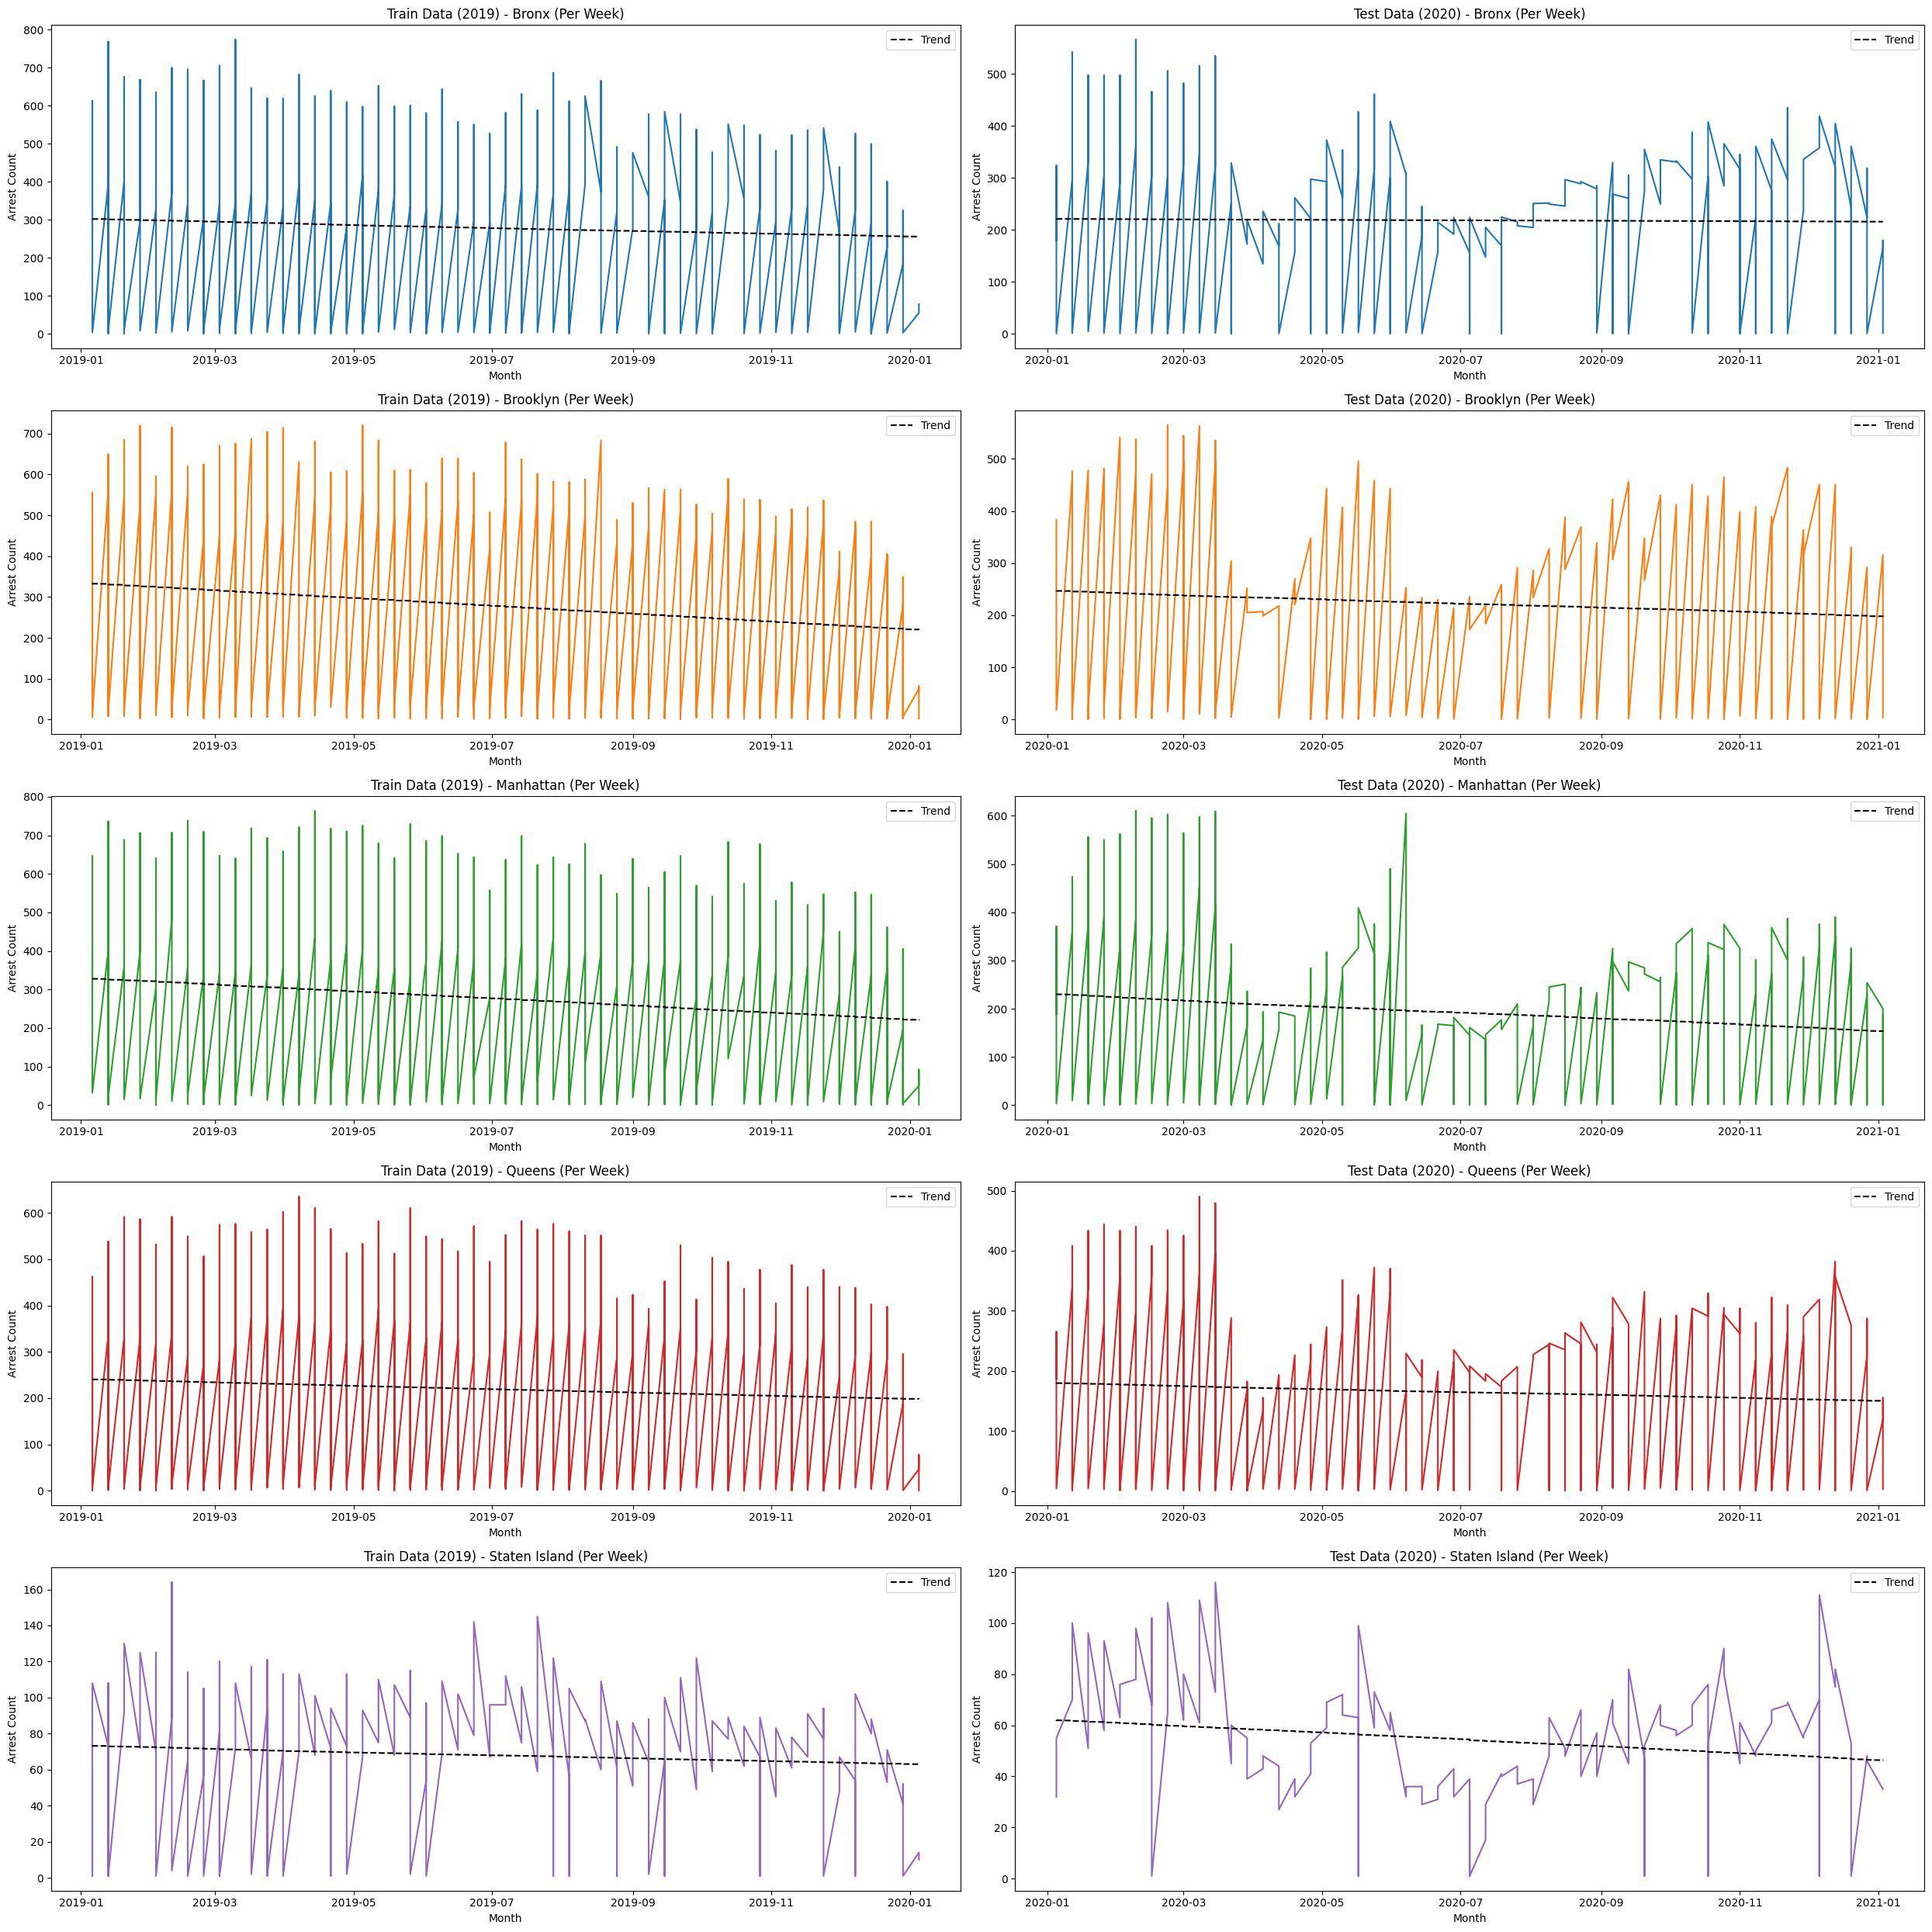

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique boroughs from the train_data and test_data
boroughs_train = train_arrest_count['ARREST_BORO'].unique()
boroughs_test = test_arrest_count['ARREST_BORO'].unique()

# Define a color palette for the boroughs
color_palette = plt.cm.get_cmap('tab10')

# Create subplots with two columns for train_data and test_data
fig, axs = plt.subplots(len(boroughs_train), 2, figsize=(25, 5*len(boroughs_train)))

# Iterate over boroughs_train and plot the time series for each borough in the train_data column
for i, borough in enumerate(boroughs_train):
    train_data_borough = train_arrest_count[train_arrest_count['ARREST_BORO'] == borough]
    color = color_palette(i % 10)
    axs[i, 0].plot(train_data_borough['ARREST_DATE'], train_data_borough['ARREST_COUNT'], color=color)
    axs[i, 0].set_xlabel('Month')
    axs[i, 0].set_ylabel('Arrest Count')
    axs[i, 0].set_title(f'Train Data (2019) - {borough} (Per Week)')

    # Calculate the trend line using linear regression
    x = np.arange(len(train_data_borough))
    trend = np.polyfit(x, train_data_borough['ARREST_COUNT'], 1)
    trend_line = np.polyval(trend, x)
    
    axs[i, 0].plot(train_data_borough['ARREST_DATE'], trend_line, color='black', linestyle='--', label='Trend')

    axs[i, 0].legend()

# Iterate over boroughs_test and plot the time series for each borough in the test_data column
for i, borough in enumerate(boroughs_test):
    test_data_borough = test_arrest_count[test_arrest_count['ARREST_BORO'] == borough]
    color = color_palette(i % 10)
    axs[i, 1].plot(test_data_borough['ARREST_DATE'], test_data_borough['ARREST_COUNT'], color=color)
    axs[i, 1].set_xlabel('Month')
    axs[i, 1].set_ylabel('Arrest Count')
    axs[i, 1].set_title(f'Test Data (2020) - {borough} (Per Week)')

    # Calculate the trend line using linear regression
    x = np.arange(len(test_data_borough))
    trend = np.polyfit(x, test_data_borough['ARREST_COUNT'], 1)
    trend_line = np.polyval(trend, x)
    
    axs[i, 1].plot(test_data_borough['ARREST_DATE'], trend_line, color='black', linestyle='--', label='Trend')

    axs[i, 1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()



In [17]:
# %pip install statsmodels
# %pip install prophet

In [18]:
train_arrest_pivot = train_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')
test_arrest_pivot = test_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')

train_arrest_pivot.head()


LAW_CAT_CD  Felony                                                I         \
ARREST_BORO  Bronx Brooklyn Manhattan Queens Staten Island Brooklyn Queens   
ARREST_DATE                                                                  
2019-01-06   275.0    473.0     310.0  282.0          59.0      6.0    1.0   
2019-01-13   394.0    561.0     402.0  337.0          73.0      8.0    2.0   
2019-01-20   402.0    547.0     361.0  331.0          92.0      8.0    4.0   
2019-01-27   297.0    525.0     400.0  330.0          72.0      3.0    1.0   
2019-02-03   327.0    555.0     305.0  318.0          70.0     10.0    1.0   

LAW_CAT_CD                Misdemeanor                                          \
ARREST_BORO Staten Island       Bronx Brooklyn Manhattan Queens Staten Island   
ARREST_DATE                                                                     
2019-01-06            1.0       613.0    556.0     646.0  462.0         108.0   
2019-01-13            1.0       768.0    649.0     736.0  538.0         108.0   
2019-01-20            NaN       675.0    685.0     688.0  591.0         130.0   
2019-01-27            NaN       668.0    719.0     706.0  586.0         125.0   
2019-02-03            NaN       635.0    595.0     640.0  532.0         125.0   

LAW_CAT_CD  Violation                               I               Violation  
ARREST_BORO     Bronx Brooklyn Manhattan Queens Bronx Manhattan Staten Island  
ARREST_DATE                                                                    
2019-01-06        4.0     14.0      32.0    7.0   NaN       NaN           NaN  
2019-01-13        8.0     20.0      22.0    7.0   1.0       1.0           1.0  
2019-01-20       12.0     22.0      15.0    9.0   1.0       NaN           NaN  
2019-01-27        8.0     24.0      17.0    8.0   NaN       NaN           NaN  
2019-02-03        2.0     17.0      17.0    9.0   NaN       1.0           1.0

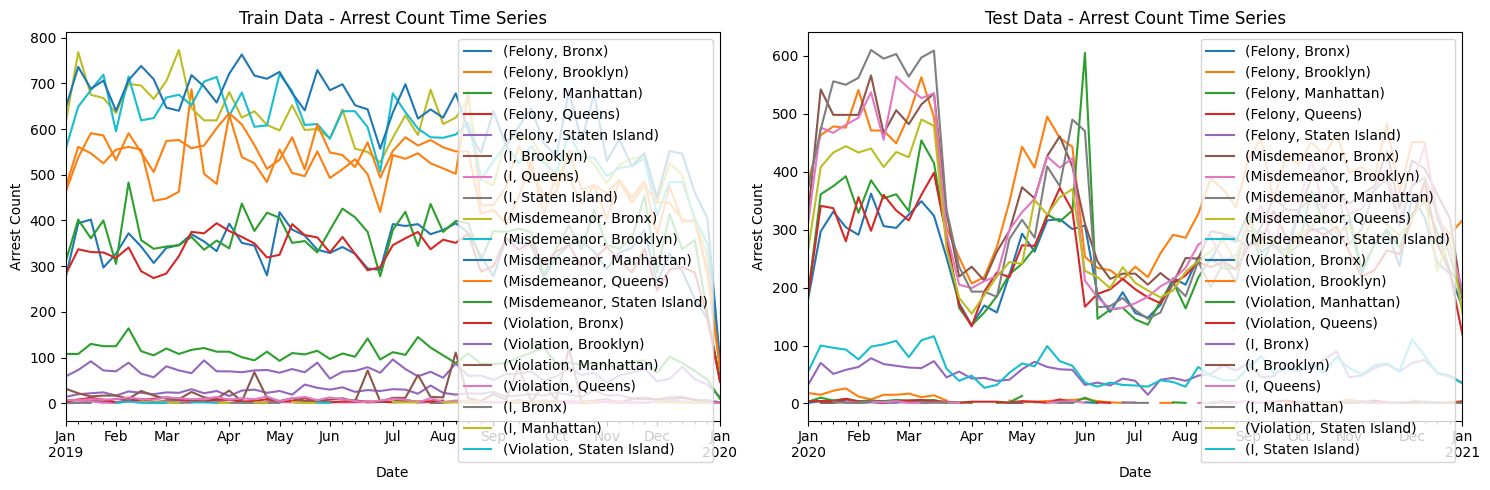

(53, 20)


In [19]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting the train data
train_arrest_pivot.plot(ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Arrest Count')
axs[0].set_title('Train Data - Arrest Count Time Series')
axs[0].legend(loc='upper right')

# Plotting the test data
test_arrest_pivot.plot(ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Arrest Count')
axs[1].set_title('Test Data - Arrest Count Time Series')
axs[1].legend(loc='upper right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

print(train_arrest_pivot.shape)

### Buscando los modelos

#### Hyperparameter Tuning for ARIMA

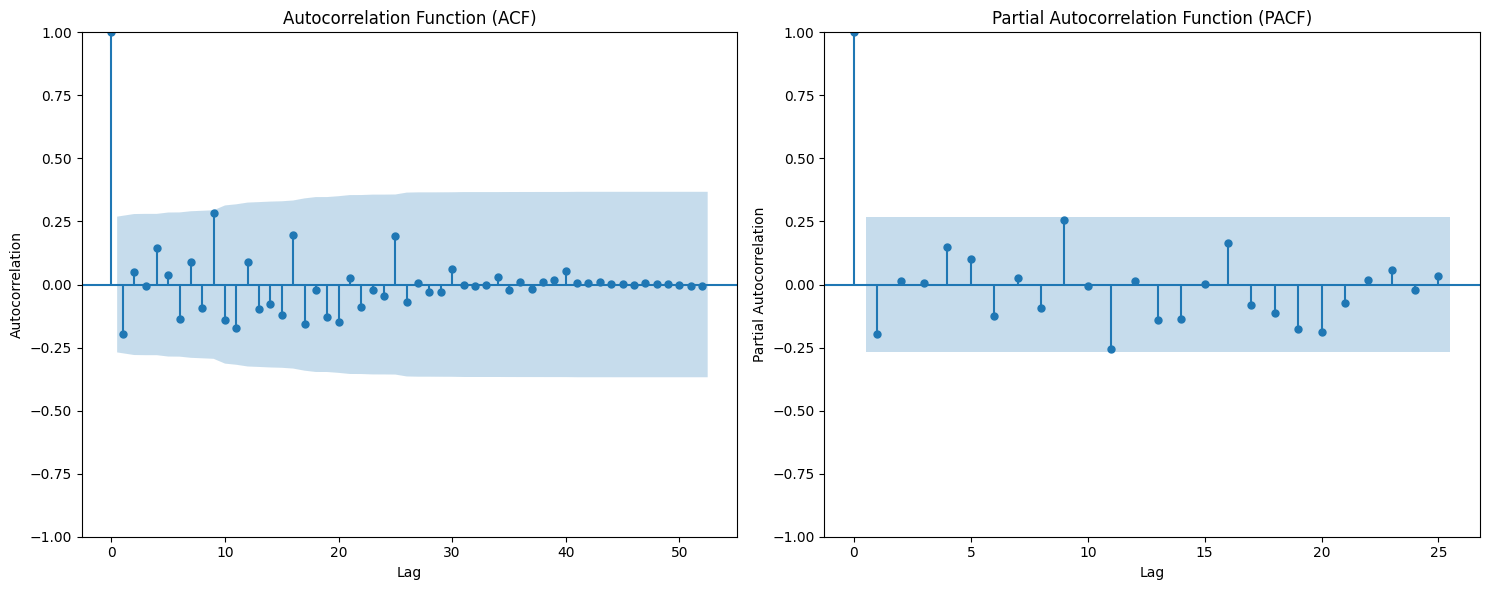

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informatio

Best AIC: 494.47826910783857
Best BIC: 498.3807565450014
Best Order: (0, 1, 1)


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [21]:
## ARIMA Hyperparameter Tuning

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data in a pandas DataFrame
data_hyp = train_arrest_pivot.xs(('Violation', 'Manhattan'), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot ACF
sm.graphics.tsa.plot_acf(data_hyp, lags=52, ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
sm.graphics.tsa.plot_pacf(data_hyp, lags=25, ax=axs[1])
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_title('Partial Autocorrelation Function (PACF)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Define a function to evaluate ARIMA models and return AIC and BIC
def evaluate_arima_model(order):
    model = sm.tsa.ARIMA(data_hyp, order=order, freq='W')
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    return aic, bic

# Define ranges for p, d, and q
p_values = range(0, 4)  # Example range for p
d_values = range(0, 2)  # Example range for d
q_values = range(0, 4)  # Example range for q

best_aic = float('inf')
best_bic = float('inf')
best_order = None

# Iterate over all possible combinations of p, d, and q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                aic, bic = evaluate_arima_model(order)
                if aic < best_aic:
                    best_aic = aic
                    best_bic = bic
                    best_order = order
            except:
                continue

print("Best AIC:", best_aic)
print("Best BIC:", best_bic)
print("Best Order:", best_order)


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informatio

No data available for Felony - Bronx
No data available for I - Bronx
No data available for Misdemeanor - Bronx
No data available for Violation - Bronx
No data available for Felony - Brooklyn
No data available for I - Brooklyn
No data available for Misdemeanor - Brooklyn
No data available for Violation - Brooklyn
No data available for Felony - Manhattan
No data available for I - Manhattan
No data available for Misdemeanor - Manhattan
No data available for Violation - Manhattan
No data available for Felony - Queens
No data available for I - Queens
No data available for Misdemeanor - Queens
No data available for Violation - Queens
No data available for Felony - Staten Island
No data available for I - Staten Island
No data available for Misdemeanor - Staten Island
No data available for Violation - Staten Island


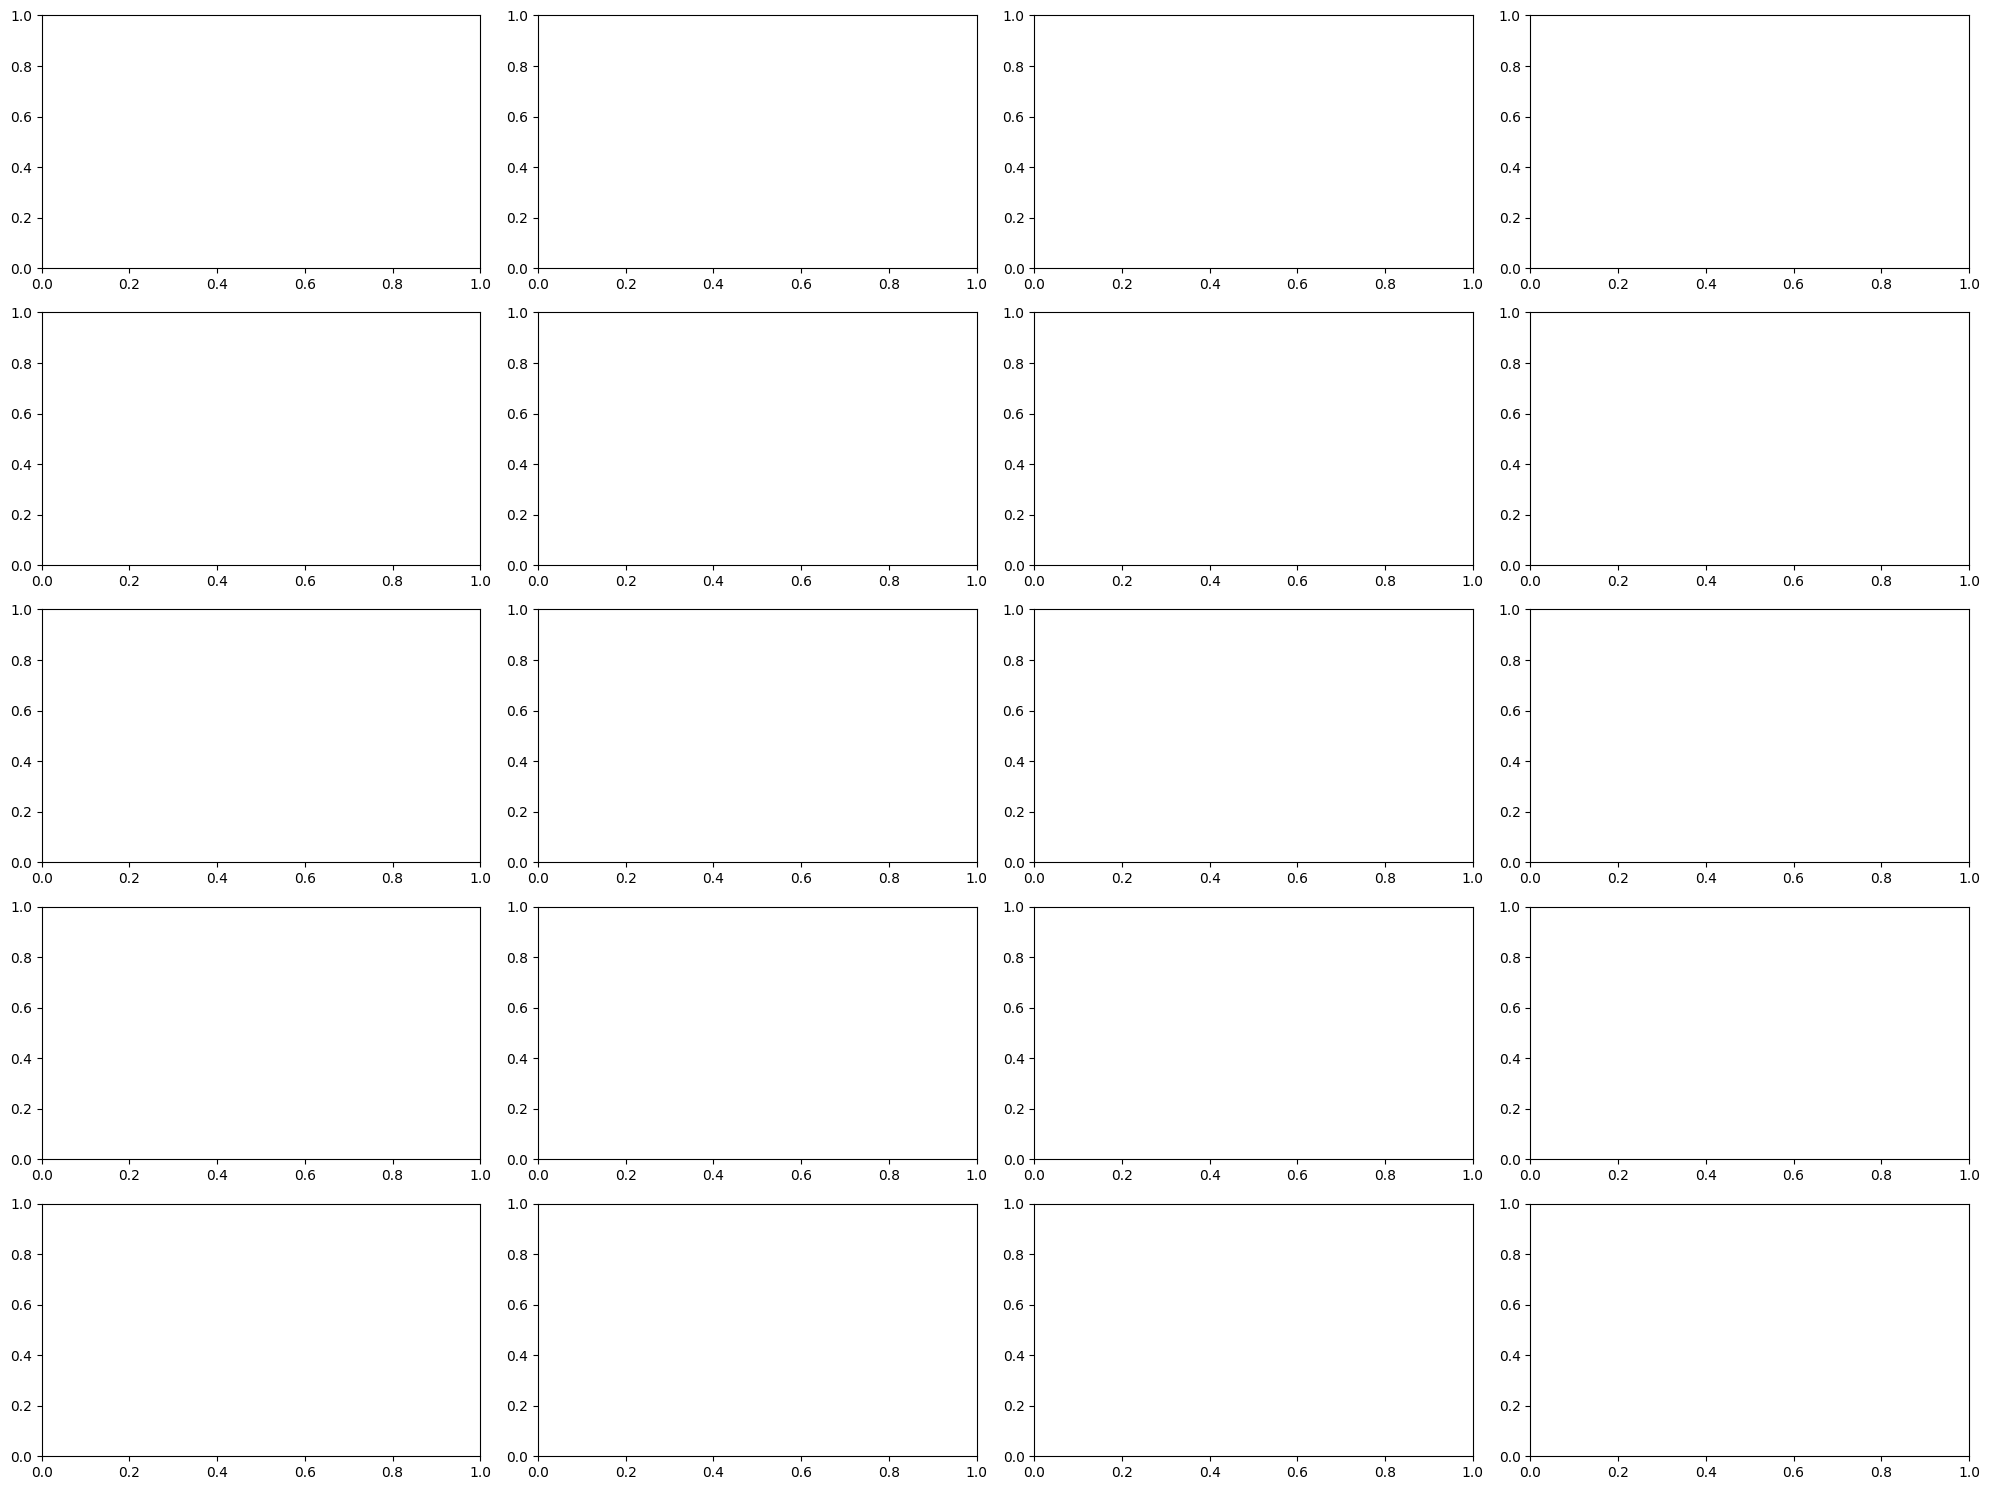

In [22]:
# Define a list to store the predictions for each borough and law category
predictions = []

# Iterate over each law category
for law_cat_cd in train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique():
    # Iterate over each borough
    for borough in train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique():
        # Prepare the data for the specific law category and borough
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        # Fit the ARIMA model with the best order to the data
        model = sm.tsa.ARIMA(data, order=best_order, freq='W')
        model_fit = model.fit()
        
        # Make predictions for the desired time period
        predictions_borough = model_fit.predict(start=len(data), end=len(data) + len(test_arrest_count) - 1)
        
        # Append the predictions to the list
        predictions.append(predictions_borough)

# Combine the predictions for all boroughs and law categories
all_predictions = pd.concat(predictions, axis=1)

# Set the column names to the appropriate boroughs and law categories
all_predictions.columns = pd.MultiIndex.from_product([train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique(),
                                                     train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()],
                                                    names=['LAW_CAT_CD', 'ARREST_BORO'])

# Plot the predictions for each borough and law category
fig, axs = plt.subplots(len(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()), len(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()), figsize=(20, 15))

for i, borough in enumerate(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()):
    for j, law_cat_cd in enumerate(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()):
        try:
            predictions = all_predictions[(law_cat_cd, borough)]
        except KeyError:
            # Handle missing predictions
            continue
        
        if (law_cat_cd, borough) in test_arrest_count.columns:
            axs[i, j].plot(test_arrest_count.index, test_arrest_count[(law_cat_cd, borough)], label='Actual')
            axs[i, j].plot(test_arrest_count.index, predictions, label='Predicted')
            axs[i, j].set_xlabel('Week')
            axs[i, j].set_ylabel('Arrest Count')
            axs[i, j].set_title(f'{law_cat_cd} - {borough}')
            axs[i, j].legend()
        else:
            print(f"No data available for {law_cat_cd} - {borough}")

plt.tight_layout()
plt.show()




### SARIMAX


In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools

def evaluate_sarima_model(order, seasonal_order):
    model = sm.tsa.SARIMAX(data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    return aic, bic

p_values = range(0, 3)  # Range for p (AR parameter)
d_values = range(0, 2)  # Range for d (integration parameter)
q_values = range(0, 3)  # Range for q (MA parameter)
P_values = range(0, 3)  # Range for P (AR parameter of the seasonal component)
D_values = range(0, 2)  # Range for D (integration parameter of the seasonal component)
Q_values = range(0, 3)  # Range for Q (MA parameter of the seasonal component)
s_values = [52]  # Seasonal period (e.g., 52 for weekly data with yearly seasonality)

best_aic = float('inf')
best_bic = float('inf')
best_order = None
best_seasonal_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)
                            try:
                                aic, bic = evaluate_sarima_model(order, seasonal_order)
                                if aic < best_aic:
                                    best_aic = aic
                                    best_bic = bic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except:
                                continue

print("Best AIC:", best_aic)
print("Best BIC:", best_bic)
print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations

In [ ]:
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-12-31')

for borough in train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique():
    for law_cat_cd in train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique():
        # Prepare the data for the specific borough and law category
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        # Fit the SARIMA model with the best order and seasonal order to the data
        model = sm.tsa.SARIMAX(data, order=best_order, seasonal_order=best_seasonal_order)
        model_fit = model.fit()
        
        # Make predictions for the specified time range
        predictions = model_fit.predict(start=start_date, end=end_date)
        
        # Print or do further processing with the predictions
        print(f'Predictions for {law_cat_cd} - {borough}:')
        print(predictions)


### PROPHET

In [ ]:
from prophet import Prophet

# Example for modeling arrests for Violation offenses in Queens
data = train_arrest_pivot.xs(("Violation", "Q"), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)

# Prepare the data in a Prophet-compatible format
df = pd.DataFrame({'ds': data.index, 'y': data.values})

# Fit the Prophet model
model = Prophet()
model.fit(df)

# Make future predictions
future_dates = pd.date_range(start='2020-01-01', end='2020-12-01', freq='M')
future = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future)


['ARREST_DATE']
DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='ARREST_DATE', freq=None)
